In [1]:
from skimage import filters
import pickle
import os
from metadata import Metadata
import time
from skimage.morphology import selem
from skimage.morphology import dilation
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import itertools as it
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops
from skimage.morphology import watershed

In [64]:
from skimage import filters
import pickle
import os
from metadata import Metadata
import time
from skimage.morphology import selem
from skimage.morphology import dilation
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import itertools as it
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops
from skimage.morphology import watershed


#This function loads images, substract background and append a list of selected images to df
def pfunc_zstk_filt(pname, threshold, md_local, acq=['tnfaip3'],
                    chan='FarRed', blur=(0.25,0.25,0.25), 
                   rel_thresh=0.2, npixels_thresh=6):
    print(pname, '\n')
    disk = selem.disk(2)
    stk = md_local.stkread(Position=pname, Channel=chan, acq=acq)#loading images
    
    #check if the type of stk is dictionary, print the position, channel, and aquisition
    if type(stk)==dict:
        print('stk empty')
        print('Pos: ',pname)
        print('Channel: ',chan)
        print('Acq: ',acq)
        
        
    # Failed to load files
    if isinstance(stk, dict):
        return None
    
   # background subtraction
    fstk = diffGauss(stk, blur)
    
    # returns the coordinates of local peaks (maxima) in an image
    peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                                  min_distance=3)
    peaks = peak_local_max(fstk, threshold_abs=threshold,
                           min_distance=3, indices=False)
    dfs = []
 
    for z in set(peaks_coords[:, 2]):
        img = fstk[:,:,z]
        labels = label(peaks[:, :, z])
        #watershed is used for image segmentation
        spot_labels = watershed(gaussian_filter(img, 1.2)*-1, labels, mask=dilation(peaks[:,:, z], selem=disk))
        spots = regionprops(spot_labels, img)#Measure properties of labeled image regions
        npixels = np.array([p.area for p in spots])#creates an array
        spot_means = np.array([p.mean_intensity for p in spots])
        spot_max = [p.max_intensity for p in spots]
        centroids = np.array([p.weighted_centroid for p in spots])
    #     rna = np.where((spot_means>threshold)&(npixels>=npixels_thresh))[0]
        rna = np.arange(len(spots))
        rna_coords = centroids[rna]
        spot_values = []
        for p in spots:
            vals = [img[y, x] for y, x in p.coords]
            spot_values.append(vals)#append coordinates to spot_value

        df = pd.DataFrame(np.stack([spot_means[rna], rna_coords[:,0],
                                    rna_coords[:, 1],
                                    tuple(it.repeat(z, len(spot_means[rna])))], axis=1),
                          columns = ['val', 'y', 'x', 'z'])#Join a sequence of arrays along new axises.
        df['pixel_values'] = spot_values
        dfs.append(df)
    
    return pname, fstk.max(axis=2), pd.concat(dfs, ignore_index=True), spot_labels


# This function sets blur magnitude and substract the background
def diffGauss(stk, blur = (0.5,0.5,0.)):
    stk = stk.astype('float64')
    stk = stk.copy()
    lp = gaussian_filter(stk, blur)
    stk = stk-lp
    stk = gaussian_filter(stk, (0.25,0.25,0.25))
    np.place(stk, stk<0, 0)
    return stk.astype('int16')

def spot_detection(md_path, data_list,threshold = 200,colors = ['Orange','FarRed'],sigmas = ['low','med','high']):
    result_path = os.path.join(md_path,'results')#function constructs a pathname out of one or more partial pathnames. 
   
    #if result_path does not exist, create result path
    if not os.path.exists(result_path):
        os.mkdir(result_path)
        
    md = Metadata(md_path)
    total_start = time.time()#record the start time
   
    #create files for each position in each acq, each sigma and each color
    #if color_path, sigma_path, acq_path, pos_path does not exist, create one
    #if they already exists, continue
    for color in colors:
        color_path = os.path.join(result_path,color)
        if not os.path.exists(color_path):
            os.mkdir(color_path)
        for sigma in sigmas:
            sigma_path = os.path.join(color_path,sigma)
            if not os.path.exists(sigma_path):
                os.mkdir(sigma_path)
            if sigma == 'low':
                blur = (2.2,2.2,2.2)
            elif sigma == 'med':
                blur = (5,5,5)
            elif sigma=='high':
                blur = (10,10,10)
            else:
                print('Unknown sigma: ',sigma)
                continue
            for acq in data_list:
                acq_path = os.path.join(sigma_path,acq)
                if os.path.exists(os.path.join(acq_path,'df.pkl')):
                    continue
                if not os.path.exists(acq_path):
                    os.mkdir(acq_path)
                start = time.time()
                poses = md.image_table[(md.image_table.Channel==color)&(md.image_table.acq==acq)].Position.unique()
                df_list = []
                for pos in poses:
                    pos_path = os.path.join(acq_path,pos)
                    if not os.path.exists(pos_path):
                        os.mkdir(pos_path)
                    if os.path.exists(os.path.join(pos_path,'pname.pkl')):
                        if os.path.exists(os.path.join(pos_path,'fstk_max.pkl')):
                            if os.path.exists(os.path.join(pos_path,'spot_labels.pkl')):
                                if os.path.exists(os.path.join(pos_path,'df.pkl')):
                                    df = pickle.load(open(os.path.join(pos_path,'df.pkl'),'rb'))
                                    df_list.append(df)
                                    print('')
                                    print(acq,sigma,color)
                                    continue
                    pname,fstk_max,df,spot_labels = pfunc_zstk_filt(pos, threshold, md, acq=acq,chan=color,blur=blur)
                    npixels = []
                    ssum = []
                    stdpixels = []
                    npixels_thresh = filters.threshold_otsu(np.array(df.val))
                    for pixel_values in df.pixel_values:
                        pixel_array = np.array(pixel_values)
                        npixels.append(len(pixel_array[pixel_array>npixels_thresh]))
                        ssum.append(np.sum(pixel_values))
                        stdpixels.append(np.std(pixel_values))
                    df['npixels'] = npixels
                    df['ssum'] = ssum
                    df['stdpixels'] = stdpixels
                    pickle.dump(pname,open(os.path.join(pos_path,'pname.pkl'),'wb'))
                    pickle.dump(fstk_max,open(os.path.join(pos_path,'fstk_max.pkl'),'wb'))
                    pickle.dump(df,open(os.path.join(pos_path,'df.pkl'),'wb'))
                    pickle.dump(spot_labels,open(os.path.join(pos_path,'spot_labels.pkl'),'wb'))
                    df_list.append(df)
                    print('')
                    print(acq,sigma,color,'time: ',time.time()-start)
                pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))
    print('Finished ')
    print('Total Time: ',time.time()-total_start)
    return

In [ ]:
for color in colors
    for sigma in sigmas
        for acq in acqs
            for pos in poses

In [136]:
md_path='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_25_and_50_2019Jul23/'
df_list = []
acq_path=os.path.join(md_path,'results','Orange','low','50nM_600ms_2')
for pos in os.listdir(acq_path):
    if 'df' in pos:
        continue
    pos_path = os.path.join(acq_path,pos)
    if os.path.exists(os.path.join(pos_path,'df.pkl')):
        df = pickle.load(open(os.path.join(pos_path,'df.pkl'),'rb'))
        df_list.append(df)
        print('')
        print(pos)
        continue
    else:
        print(pos,' df doesnt exist')
df = pd.concat(df_list,axis=0,ignore_index=False)
pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))
print('Finished ')


Pos15

Pos13

Pos8

Pos5

Pos0

Pos19

Pos1

Pos17

Pos14

Pos18

Pos6

Pos9

Pos4

Pos10

Pos16

Pos2

Pos11

Pos3

Pos7

Pos12
Finished 


In [137]:
pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))

In [28]:
import matplotlib.pyplot as plt
def plot_spot_histograms(per_conc_list, exposure_list,df_output1, df_output2,colors = ['Orange','FarRed'],sigmas = ['low','med','high']):
    %matplotlib inline
    for color in colors:
        print(color)
        for sigma in sigmas:
            print(sigma)
            for exposure in exposure_list:
                print (exposure)
                for per in per_conc_list:
                    try:
                        acq = [i for i in df_output1[color][sigma].keys() if exposure in i and per in i]
                        print(acq)
                        df = df_output1[color][sigma][acq[0]]['df']
                    except:
                        acq = [i for i in df_output2[color][sigma].keys() if exposure in i and per in i]
                        if len(acq) == 0:
                            print('Error')
                            print(acq)
                        df = df_output2[color][sigma][acq[0]]['df']
                    plt.hist(np.log10(df.val),bins=100,label=acq,alpha=0.5)   
                plt.xlabel('intensity')
                plt.ylabel('counts')
                plt.title(str(color+' '+sigma))
                plt.legend()
                plt.show()
    return

In [59]:
md_path = '/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_5_and_100_2019Jul02/'
output = pickle.load(open(os.path.join(md_path,'output.pkl'),'rb'))
df_output = pickle.load(open(os.path.join(md_path,'df_output.pkl'),'rb'))
results_path = os.path.join(md_path,'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)
for pos in output.keys():
    print(pos)
    for color in output[pos].keys():
        print(color)
        color_path = os.path.join(results_path,color)
        if not os.path.exists(color_path):
            os.mkdir(color_path)
        for sigma in output[pos][color].keys():
            print(sigma)
            sigma_path = os.path.join(color_path,sigma)
            if not os.path.exists(sigma_path):
                os.mkdir(sigma_path)
            for acq in output[pos][color][sigma].keys():
                print(acq)
                acq_path = os.path.join(sigma_path,acq)
                if not os.path.exists(acq_path):
                    os.mkdir(acq_path)
                pos_path = os.path.join(acq_path,pos)
                if not os.path.exists(pos_path):
                    os.mkdir(pos_path)
                pname = output[pos][color][sigma][acq]['pname']
                fstk_max = output[pos][color][sigma][acq]['fstk_max']
                df = output[pos][color][sigma][acq]['df']
                spot_labels = output[pos][color][sigma][acq]['spot_labels']
                pickle.dump(pname,open(os.path.join(pos_path,'pname.pkl'),'wb'))
                pickle.dump(fstk_max,open(os.path.join(pos_path,'fstk_max.pkl'),'wb'))
                pickle.dump(df,open(os.path.join(pos_path,'df.pkl'),'wb'))
                pickle.dump(spot_labels,open(os.path.join(pos_path,'spot_labels.pkl'),'wb'))
for color in df_output.keys():
    color_path = os.path.join(results_path,color)
    if not os.path.exists(color_path):
        os.mkdir(color_path)
    for sigma in df_output[color].keys():
        sigma_path = os.path.join(color_path,sigma)
        if not os.path.exists(sigma_path):
            os.mkdir(sigma_path)
        for acq in df_output[color][sigma].keys():
            acq_path = os.path.join(sigma_path,acq)
            if not os.path.exists(acq_path):
                os.mkdir(acq_path)
            df = df_output[color][sigma][acq]['df']
            pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))

KeyError: 'Pos10'

In [60]:
for color in df_output.keys():
    color_path = os.path.join(results_path,color)
    if not os.path.exists(color_path):
        os.mkdir(color_path)
    for sigma in df_output[color].keys():
        sigma_path = os.path.join(color_path,sigma)
        if not os.path.exists(sigma_path):
            os.mkdir(sigma_path)
        for acq in df_output[color][sigma].keys():
            acq_path = os.path.join(sigma_path,acq)
            if not os.path.exists(acq_path):
                os.mkdir(acq_path)
            df = df_output[color][sigma][acq]['df']
            pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))

In [76]:
import matplotlib.pyplot as plt
def load_plot_spot_histograms(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high']):
    %matplotlib inline
    results_path = os.path.join(md_path,'results')
    if colors==True:
        colors = os.listdir(results_path)#create file or directory
    for color in colors:
        print(color)
        color_path = os.path.join(results_path,'color')
        if sigmas==True:
            sigmas = os.listdir(color_path)
        for sigma in sigmas:
            print(sigma)
            sigma_path = os.path.join(color_path,'sigma')
            for acq in os.listdir(sigma_path):
                acq_path = os.path.join(sigma_path,'acq')
                df = pickle.load(open(os.path.join(sigma_path,'df'),'rb'))
                plt.hist(np.log10(df.val),bins=100,label=acq,alpha=0.5) 
            sigma_path = os.path.join(md_path2,'results','color','sigma')
            for acq in os.listdir(sigma_path):
                acq_path = os.path.join(sigma_path,'acq')
                df = pickle.load(open(os.path.join(acq_path,'df'),'rb'))
                plt.hist(np.log10(df.val),bins=100,label=acq,alpha=0.5) 
            plt.xlabel('intensity')
            plt.ylabel('counts')
            plt.title(str(color+' '+sigma))
            plt.legend()
            plt.show()
    return

In [87]:
import matplotlib.pyplot as plt
def load_plot_spot_histograms(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high'],exposures=['100ms','600ms']):
    %matplotlib inline
    results_path = os.path.join(md_path,'results')#join path components
    if colors==True:
        colors = os.listdir(results_path)#returns a list containing the names of the entries in the directory given by path
    for color in colors:
        print(color)
        color_path = os.path.join(results_path,color)
        if sigmas==True:
            sigmas = os.listdir(color_path)
        for sigma in sigmas:
            print(sigma)
            for exposure in exposures:
                sigma_path = os.path.join(color_path,sigma)
                for acq in os.listdir(sigma_path):
                    if exposure in acq:
                        acq_path = os.path.join(sigma_path,acq)
                        df = pickle.load(open(os.path.join(acq_path,'df.pkl'),'rb'))
                        plt.hist(np.log10(df.val),bins=100,label=acq,alpha=0.5) 
                sigma_path = os.path.join(md_path2,'results',color,sigma)
                for acq in os.listdir(sigma_path):
                    if exposure in acq:
                        acq_path = os.path.join(sigma_path,acq)
                        df = pickle.load(open(os.path.join(acq_path,'df.pkl'),'rb'))
                        plt.hist(np.log10(df.val),bins=100,label=acq,alpha=0.5) 
                plt.xlabel('intensity')
                plt.ylabel('counts')
                plt.title(str(color+' '+sigma+' '+exposure))
                plt.legend()
                plt.show()
    return

Orange
low


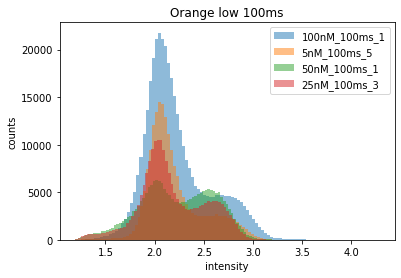

/home/rotation/anaconda3/envs/Michelle_pyspots/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/home/rotation/anaconda3/envs/Michelle_pyspots/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


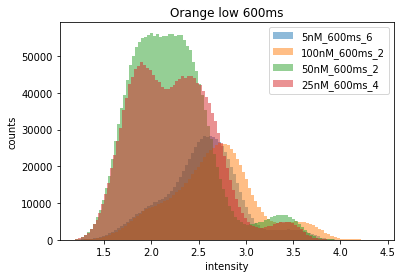

med


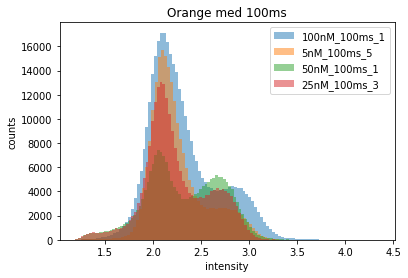

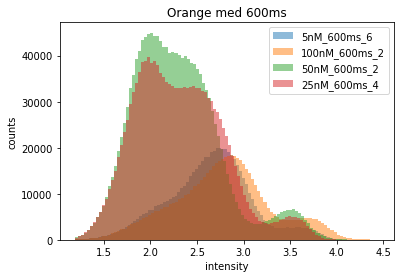

high


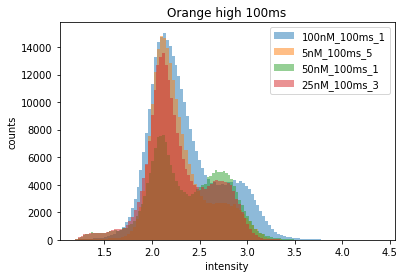

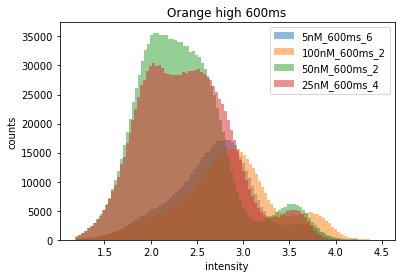

FarRed
low


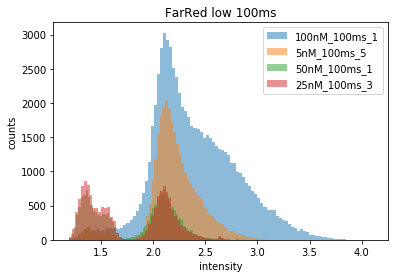

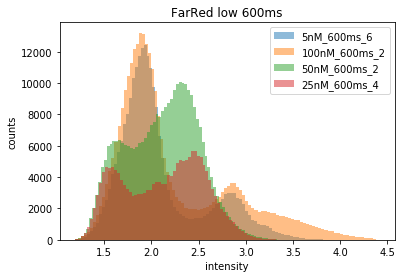

med


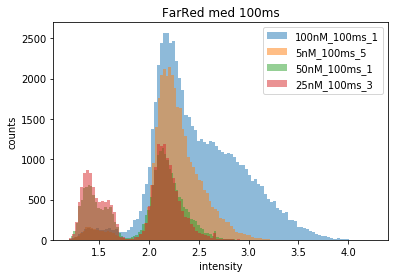

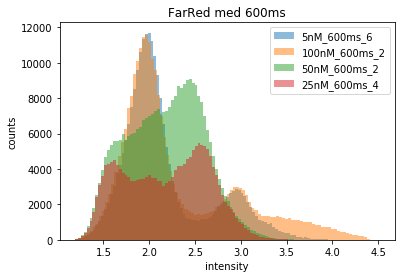

high


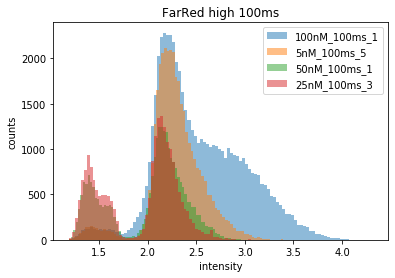

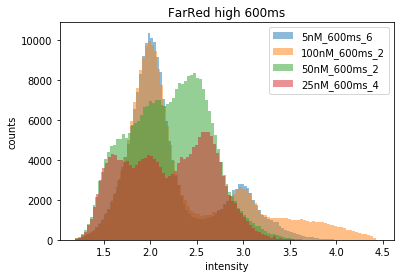

In [88]:
md_path2='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_25_and_50_2019Jul23/'
md_path='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_5_and_100_2019Jul02/'
load_plot_spot_histograms(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high'])

In [95]:
import matplotlib.pyplot as plt
def bg_signal_histogram(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high'],exposures=['100ms','600ms']):
    %matplotlib inline
    results_path = os.path.join(md_path,'results')#join path components
    if colors==True:
        colors = os.listdir(results_path)#returns a list containing the names of the entries in the directory given by path
    for color in colors:
        print(color)
        color_path = os.path.join(results_path,color)
        if sigmas==True:
            sigmas = os.listdir(color_path)
        for sigma in sigmas:
            print(sigma)
            sigma_path = os.path.join(color_path,sigma)
            for acq in os.listdir(sigma_path):
                acq_path = os.path.join(sigma_path,acq)
                df = pickle.load(open(os.path.join(acq_path,'df.pkl'),'rb'))

                intensity_thresh = filters.threshold_otsu(np.array(df.val))
                npixels_thresh = 0
                ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
                std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
                good_df = df[(df.val>intensity_thresh)&(np.array(df.npixels)>npixels_thresh)&(np.array(df.ssum)>ssum_thresh)&(np.array(df.stdpixels)>std_thresh)]
                bad_df = df[(df.val<=intensity_thresh)&(np.array(df.npixels)<=npixels_thresh)&(np.array(df.ssum)<=ssum_thresh)&(np.array(df.stdpixels)<=std_thresh)]
                pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))
                plt.hist(np.log10(good_df.val),bins=100,color='r',alpha=0.5)
                plt.hist(np.log10(bad_df.val),bins=100,color='b',alpha=0.5)
                plt.xlabel('intensity')
                plt.ylabel('counts')
                plt.title(str(color+' '+sigma+' '+acq))
                plt.legend()
                plt.show()
            sigma_path = os.path.join(md_path2,'results',color,sigma)
            for acq in os.listdir(sigma_path):
                acq_path = os.path.join(sigma_path,acq)
                df = pickle.load(open(os.path.join(acq_path,'df.pkl'),'rb'))
                intensity_thresh = filters.threshold_otsu(np.array(df.val))
                npixels_thresh = 0
                ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
                std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
                good_df= df[(df.val>intensity_thresh)&(np.array(df.npixels)>npixels_thresh)&(np.array(df.ssum)>ssum_thresh)&(np.array(df.stdpixels)>std_thresh)]
                bad_df = df[(df.val<=intensity_thresh)&(np.array(df.npixels)<=npixels_thresh)&(np.array(df.ssum)<=ssum_thresh)&(np.array(df.stdpixels)<=std_thresh)]
                plt.hist(np.log10(good_df.val),bins=100,color='r',alpha=0.5)
                plt.hist(np.log10(bad_df.val),bins=100,color='b',alpha=0.5)
                pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))
                plt.xlabel('intensity')
                plt.ylabel('counts')
                plt.title(str(color+' '+sigma+' '+acq))
                plt.legend()
                plt.show()
    return

  

Orange
low


No handles with labels found to put in legend.


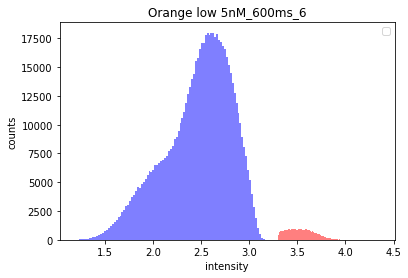

No handles with labels found to put in legend.


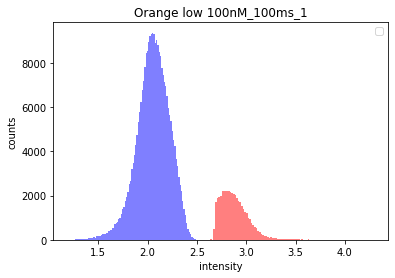

No handles with labels found to put in legend.


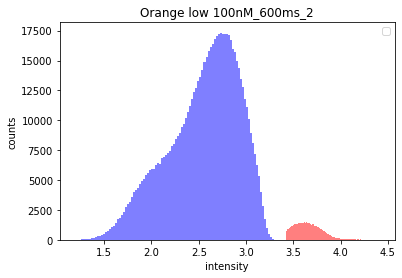

No handles with labels found to put in legend.


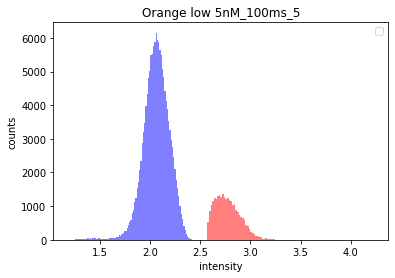

No handles with labels found to put in legend.


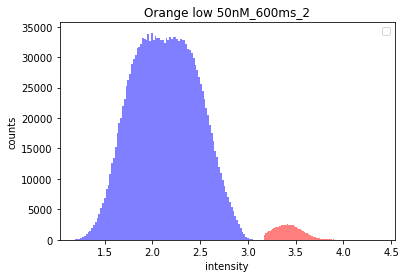

No handles with labels found to put in legend.


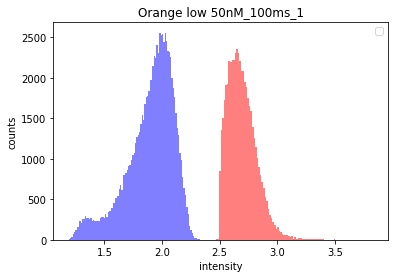

No handles with labels found to put in legend.


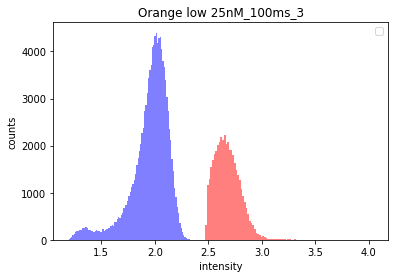

No handles with labels found to put in legend.


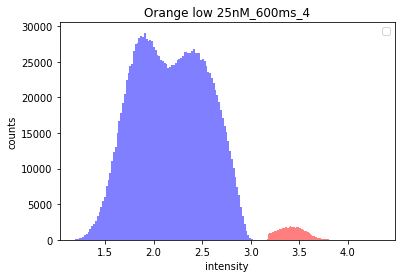

med


No handles with labels found to put in legend.


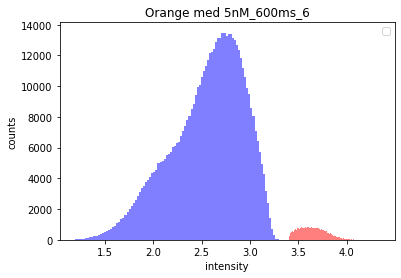

No handles with labels found to put in legend.


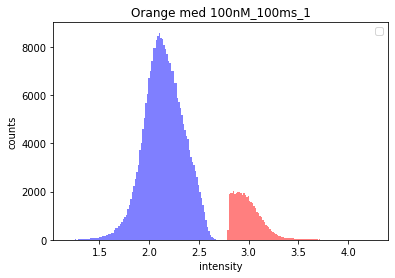

No handles with labels found to put in legend.


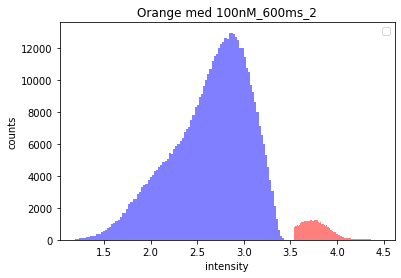

No handles with labels found to put in legend.


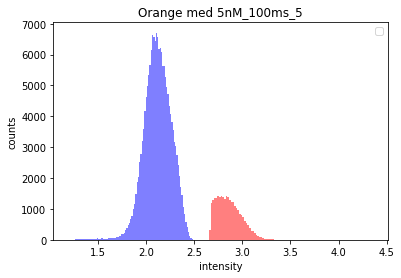

No handles with labels found to put in legend.


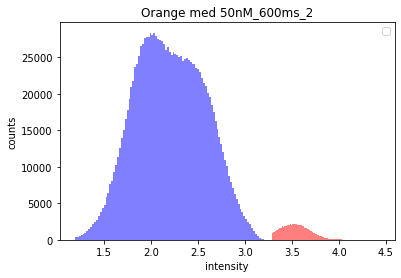

No handles with labels found to put in legend.


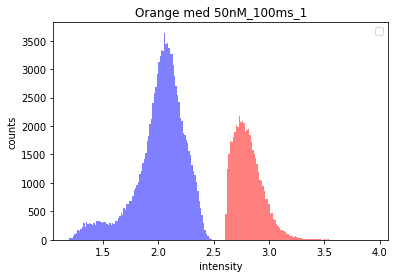

No handles with labels found to put in legend.


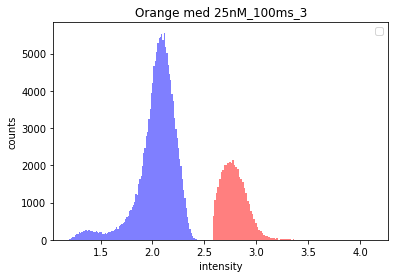

No handles with labels found to put in legend.


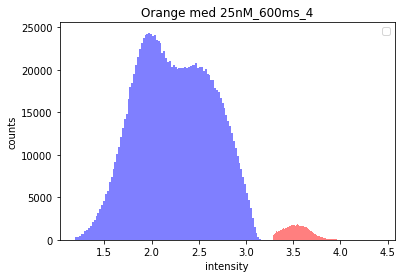

high


No handles with labels found to put in legend.


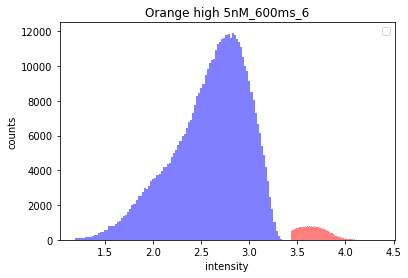

No handles with labels found to put in legend.


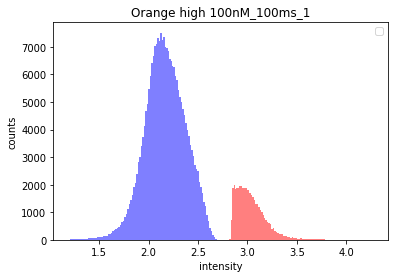

No handles with labels found to put in legend.


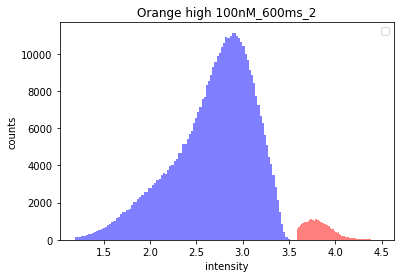

No handles with labels found to put in legend.


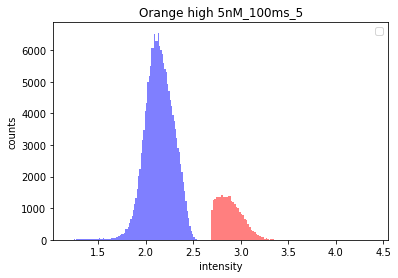

No handles with labels found to put in legend.


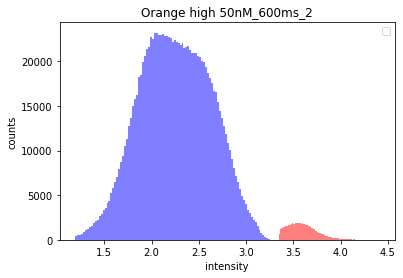

No handles with labels found to put in legend.


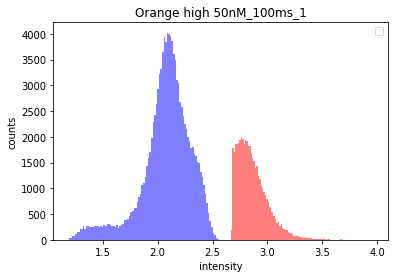

No handles with labels found to put in legend.


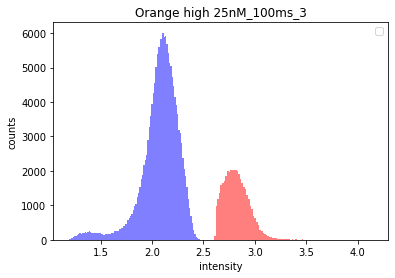

KeyboardInterrupt: 

In [96]:
md_path2='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_25_and_50_2019Jul23/'
md_path='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_5_and_100_2019Jul02/'
bg_signal_histogram(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high'],exposures=['100ms','600ms'])

In [8]:
import matplotlib.pyplot as plt
def bg_to_signal_ratio(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high'],exposures=['100ms','600ms']):
    %matplotlib inline
    results_path = os.path.join(md_path,'results')#join path components
    if colors==True:
        colors = os.listdir(results_path)#returns a list containing the names of the entries in the directory given by path
    for color in colors:
        print(color)
        color_path = os.path.join(results_path,color)
        if sigmas==True:
            sigmas = os.listdir(color_path)
        for sigma in sigmas:
            print(sigma)
            sigma_path = os.path.join(color_path,sigma)
            acq_dict = {}
            s2n_dict = {}
            for exposure in exposures:
                acq_dict[exposure]=[]
                s2n_dict[exposure]=[]

            for acq in os.listdir(sigma_path):
                print (acq)
                acq_path = os.path.join(sigma_path,acq)
                df = pickle.load(open(os.path.join(acq_path,'df.pkl'),'rb'))

                intensity_thresh = filters.threshold_otsu(np.array(df.val))
                npixels_thresh = 0
                ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
                std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
                good_df = df[(df.val>intensity_thresh)&(np.array(df.npixels)>npixels_thresh)&(np.array(df.ssum)>ssum_thresh)&(np.array(df.stdpixels)>std_thresh)]
                bad_df = df[(df.val<=intensity_thresh)&(np.array(df.npixels)<=npixels_thresh)&(np.array(df.ssum)<=ssum_thresh)&(np.array(df.stdpixels)<=std_thresh)]
                pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))
                good_df_mean=np.mean(good_df.val)
                bad_df_mean=np.mean(bad_df.val)
                ratio=good_df_mean/bad_df_mean
                for exposure in exposures:
                    if exposure in acq:
                        acq_dict[exposure].append(int(acq.split('nM')[0]))
                        s2n_dict[exposure].append(ratio)
                #acq_dict.append(acq)
                #s2n_dict.append(ratio)
                print('good_df_mean: ',good_df_mean)
                print('good_df_mean: ',bad_df_mean)
                print('background_to_signal ratio: ',ratio)
               
            
            sigma_path = os.path.join(md_path2,'results',color,sigma)
            for acq in os.listdir(sigma_path):
                print(acq)
                acq_path = os.path.join(sigma_path,acq)
                df = pickle.load(open(os.path.join(acq_path,'df.pkl'),'rb'))
                intensity_thresh = filters.threshold_otsu(np.array(df.val))
                npixels_thresh = 0
                ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
                std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
                good_df= df[(df.val>intensity_thresh)&(np.array(df.npixels)>npixels_thresh)&(np.array(df.ssum)>ssum_thresh)&(np.array(df.stdpixels)>std_thresh)]
                bad_df = df[(df.val<=intensity_thresh)&(np.array(df.npixels)<=npixels_thresh)&(np.array(df.ssum)<=ssum_thresh)&(np.array(df.stdpixels)<=std_thresh)]
                good_df_mean=np.mean(good_df.val)
                bad_df_mean=np.mean(bad_df.val)
                ratio=good_df_mean/bad_df_mean
                for exposure in exposures:
                    if exposure in acq:
                        acq_dict[exposure].append(int(acq.split('nM')[0]))
                        s2n_dict[exposure].append(ratio)
                #acq_dict.append(acq)
                #s2n_dict.append(ratio)
                print('good_df_mean: ',good_df_mean)
                print('good_df_mean: ',bad_df_mean)
                print('background_to_signal ratio: ',ratio)
            for exposure in exposures:
                plt.scatter(acq_dict[exposure], s2n_dict[exposure])
                plt.xlabel('[PER] (nM)')
                plt.ylabel('signal_to_background ratio')
                plt.title(str(color+' '+sigma+' '+exposure))
                plt.legend()
                plt.show()
               
    return

Orange
low
50nM_600ms_2
good_df_mean:  2846.9264037555463
good_df_mean:  180.24935153624088
background_to_signal ratio:  15.794378062897742
50nM_100ms_1
good_df_mean:  517.6412628232733
good_df_mean:  89.51349305247284
background_to_signal ratio:  5.782829439130834
25nM_100ms_3
good_df_mean:  500.9265240919172
good_df_mean:  96.47406284712605
background_to_signal ratio:  5.192344028111383
25nM_600ms_4
good_df_mean:  2822.624795335864
good_df_mean:  210.0739159615315
background_to_signal ratio:  13.43634112029758
5nM_600ms_6
good_df_mean:  3641.0719481547458
good_df_mean:  380.27511343383117
background_to_signal ratio:  9.574836268606626
100nM_100ms_1
good_df_mean:  820.2889640026337
good_df_mean:  121.42372056076285
background_to_signal ratio:  6.755590754544083
100nM_600ms_2
good_df_mean:  4872.985315926614
good_df_mean:  480.1990344510594
background_to_signal ratio:  10.147844885813189
5nM_100ms_5


No handles with labels found to put in legend.


good_df_mean:  626.1712406015859
good_df_mean:  120.22748633099776
background_to_signal ratio:  5.208220347198115


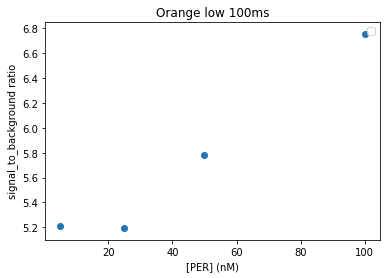

No handles with labels found to put in legend.


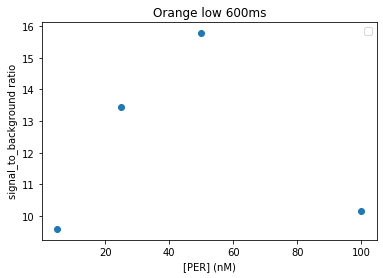

med
50nM_600ms_2
good_df_mean:  3776.8037893016804
good_df_mean:  219.697656806142
background_to_signal ratio:  17.190915206866666
50nM_100ms_1
good_df_mean:  686.998971570247
good_df_mean:  116.26365736537629
background_to_signal ratio:  5.908974370307721
25nM_100ms_3
good_df_mean:  643.4178525850372
good_df_mean:  120.34731586445811
background_to_signal ratio:  5.346341527963037
25nM_600ms_4
good_df_mean:  3652.2057332948016
good_df_mean:  260.11022955404155
background_to_signal ratio:  14.040992311438503
5nM_600ms_6
good_df_mean:  4674.262476858433
good_df_mean:  489.52126176882354
background_to_signal ratio:  9.548640359294248
100nM_100ms_1
good_df_mean:  1066.2742272431872
good_df_mean:  154.78504911467172
background_to_signal ratio:  6.888741731465571
100nM_600ms_2
good_df_mean:  6404.364824620847
good_df_mean:  626.9331446902765
background_to_signal ratio:  10.215387204938402
5nM_100ms_5


No handles with labels found to put in legend.


good_df_mean:  768.0715495116402
good_df_mean:  138.58687394889202
background_to_signal ratio:  5.542166639785014


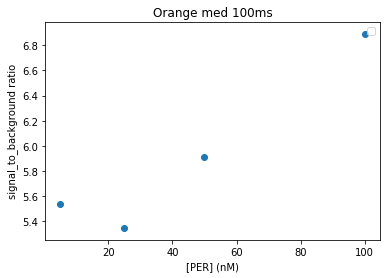

No handles with labels found to put in legend.


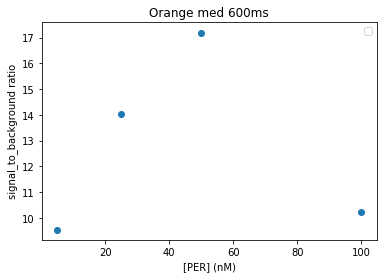

high
50nM_600ms_2
good_df_mean:  4238.164380751463
good_df_mean:  247.57177598092505
background_to_signal ratio:  17.118931929777027
50nM_100ms_1
good_df_mean:  776.4066865156317
good_df_mean:  132.88170959499715
background_to_signal ratio:  5.842840891210678
25nM_100ms_3
good_df_mean:  694.2299015761695
good_df_mean:  131.59068843782356
background_to_signal ratio:  5.2756764921417085
25nM_600ms_4
good_df_mean:  3934.9265805302043
good_df_mean:  299.723282867821
background_to_signal ratio:  13.12853156711726
5nM_600ms_6
good_df_mean:  4960.4245512073285
good_df_mean:  539.0908605223169
background_to_signal ratio:  9.201462896998938
100nM_100ms_1
good_df_mean:  1178.4550890086628
good_df_mean:  163.2816428653378
background_to_signal ratio:  7.21731523720987
100nM_600ms_2
good_df_mean:  7134.427782337841
good_df_mean:  705.3271875299183
background_to_signal ratio:  10.115061362263475
5nM_100ms_5


No handles with labels found to put in legend.


good_df_mean:  815.3251486866736
good_df_mean:  146.9506085301028
background_to_signal ratio:  5.548293789607917


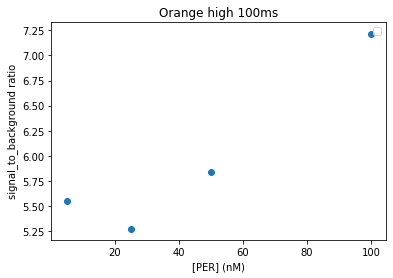

No handles with labels found to put in legend.


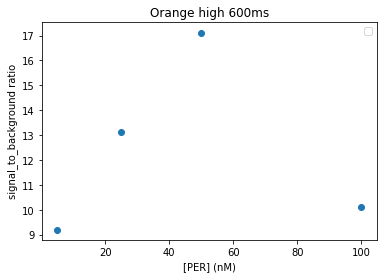

FarRed
low
50nM_600ms_2
good_df_mean:  1939.330374753452
good_df_mean:  83.28273689153208
background_to_signal ratio:  23.286102824397414
50nM_100ms_1
good_df_mean:  481.3333333333333
good_df_mean:  30.035577467241307
background_to_signal ratio:  16.02543962600039
25nM_100ms_3
good_df_mean:  9925.923076923076
good_df_mean:  76.26993986497217
background_to_signal ratio:  130.14200738188424
25nM_600ms_4
good_df_mean:  2473.795604395604
good_df_mean:  82.81622362750245
background_to_signal ratio:  29.87090567570967
5nM_600ms_6
good_df_mean:  1422.9232848175996
good_df_mean:  100.19579632708118
background_to_signal ratio:  14.201426975764333
100nM_100ms_1
good_df_mean:  2041.7242774347114
good_df_mean:  236.92989694503237
background_to_signal ratio:  8.617419345387175
100nM_600ms_2
good_df_mean:  8722.3114928706
good_df_mean:  301.4335262802848
background_to_signal ratio:  28.936102763699385
5nM_100ms_5


No handles with labels found to put in legend.


good_df_mean:  507.03748389844844
good_df_mean:  122.04043204068505
background_to_signal ratio:  4.154668050744163


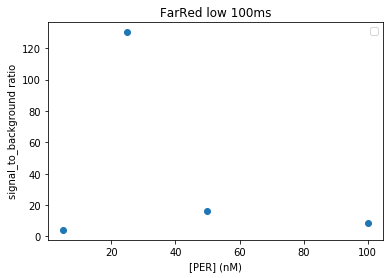

No handles with labels found to put in legend.


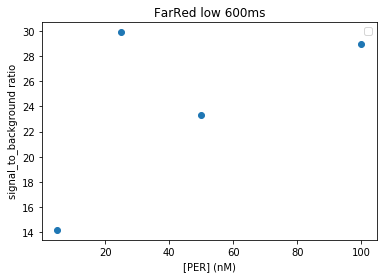

med
50nM_600ms_2
good_df_mean:  2110.839250493097
good_df_mean:  116.6158162337813
background_to_signal ratio:  18.10079729032183
50nM_100ms_1
good_df_mean:  535.9397590361446
good_df_mean:  64.67335383597137
background_to_signal ratio:  8.286871288528328
25nM_100ms_3
good_df_mean:  14368.153846153846
good_df_mean:  98.31500447593537
background_to_signal ratio:  146.14405931976282
25nM_600ms_4
good_df_mean:  2783.6638566912534
good_df_mean:  96.05275484286786
background_to_signal ratio:  28.98057282422595
5nM_600ms_6
good_df_mean:  1938.8745574446511
good_df_mean:  128.7500362160502
background_to_signal ratio:  15.059215627645374
100nM_100ms_1
good_df_mean:  2893.1250827723097
good_df_mean:  312.7847618494985
background_to_signal ratio:  9.24957170440542
100nM_600ms_2
good_df_mean:  12738.917708051487
good_df_mean:  371.0905111467778
background_to_signal ratio:  34.32833048919661
5nM_100ms_5


No handles with labels found to put in legend.


good_df_mean:  630.8713026777581
good_df_mean:  149.46817620336154
background_to_signal ratio:  4.220773402757087


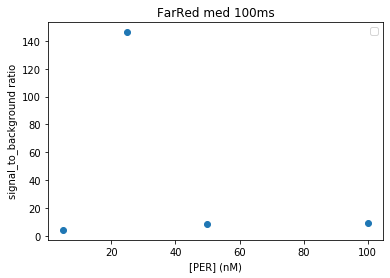

No handles with labels found to put in legend.


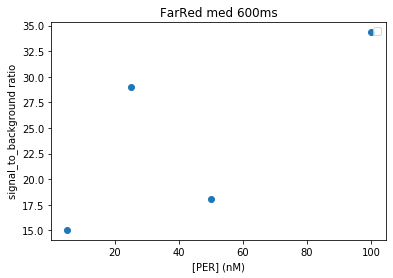

high
50nM_600ms_2
good_df_mean:  2004.8611806797855
good_df_mean:  132.8483410090943
background_to_signal ratio:  15.091352782061014
50nM_100ms_1
good_df_mean:  544.2209302325581
good_df_mean:  100.23019652413193
background_to_signal ratio:  5.429710297949268
25nM_100ms_3
good_df_mean:  16253.846153846154
good_df_mean:  105.5236639219197
background_to_signal ratio:  154.03034305056815
25nM_600ms_4
good_df_mean:  2750.487881981033
good_df_mean:  96.73150202950113
background_to_signal ratio:  28.434251761563573
5nM_600ms_6
good_df_mean:  2189.3343432146794
good_df_mean:  141.6761016489399
background_to_signal ratio:  15.453095601399626
100nM_100ms_1
good_df_mean:  3238.8545958182776
good_df_mean:  347.6796573274178
background_to_signal ratio:  9.315628704638808
100nM_600ms_2
good_df_mean:  12446.562997841129
good_df_mean:  405.3073118251862
background_to_signal ratio:  30.70895252738366
5nM_100ms_5


No handles with labels found to put in legend.


good_df_mean:  676.835237389045
good_df_mean:  158.0774324274127
background_to_signal ratio:  4.2816689706789095


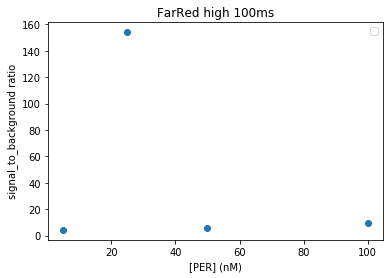

No handles with labels found to put in legend.


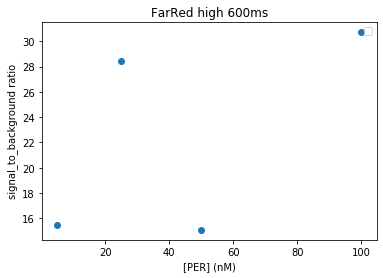

In [9]:
md_path='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_25_and_50_2019Jul23/'
md_path2='/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_5_and_100_2019Jul02/'
bg_to_signal_ratio(md_path,md_path2,colors = ['Orange','FarRed'],sigmas = ['low','med','high'],exposures=['100ms','600ms'])

In [143]:
df


,val,y,x,z,pixel_values
0,59.461538,2.816300,46.950841,3.0,"[60, 3, 0, 73, 7, 168, 293, 115, 0, 41, 13, 0, 0]"
1,47.076923,2.490196,798.138889,3.0,"[121, 0, 70, 0, 0, 0, 336, 85, 0, 0, 0, 0, 0]"
2,94.076923,2.825838,812.659035,3.0,"[99, 96, 92, 114, 151, 62, 249, 73, 0, 144, 14..."
3,47.461538,3.291734,857.753647,3.0,"[0, 83, 0, 0, 0, 0, 227, 44, 0, 140, 96, 27, 0]"
4,41.692308,3.562731,891.763838,3.0,"[0, 0, 0, 4, 103, 0, 222, 0, 37, 0, 43, 0, 133]"
5,47.230769,2.863192,981.941368,3.0,"[85, 0, 0, 66, 35, 84, 227, 0, 0, 15, 0, 67, 35]"
6,66.153846,4.626744,716.870930,3.0,"[107, 50, 213, 0, 0, 69, 290, 0, 0, 49, 0, 57,..."
7,36.923077,5.691667,1684.837500,3.0,"[10, 0, 0, 7, 0, 0, 217, 0, 0, 85, 48, 0, 113]"
8,32.692308,8.275294,62.757647,3.0,"[0, 34, 0, 0, 0, 34, 258, 0, 0, 41, 0, 6, 52]"
9,53.153846,9.098408,82.976845,3.0,"[0, 38, 35, 17, 0, 63, 232, 70, 78, 158, 0, 0, 0]"


In [128]:
df = pickle.load(open(os.path.join(md_path,'results','Orange','med','50nM_600ms_2','df.pkl'),'rb'))

In [57]:
os.listdir(md_path)

['50nM_600ms_2', 'flt_.tif', '50nM_100ms_1', '25nM_100ms_3', '25nM_600ms_4']

In [65]:
md_path = '/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_25_and_50_2019Jul23/'
data_list = ['25nM_100ms_3','25nM_600ms_4','50nM_100ms_1','50nM_600ms_2']
spot_detection(md_path, data_list)


Finished 
Total Time:  0.0023756027221679688


In [66]:
md = Metadata(md_path)

In [67]:
md.image_table


,FlatField,df_pos,linescan,Position,group,acq,frame,TimestampImage,XY,PixelSize,...,Z,Zindex,XYbeforeTransform,Exposure,Channel,Triggered,Skip,TimestampFrame,filename,root_pth
0,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665150,"[-4084.0, -6640.0]",0.1032,...,3135.728,1,"[-4083.579, -6640.06]",600,FarRed,False,1,737629.665162,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000001_000000000_FarRed_000_0...
1,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665160,"[-4084.0, -6640.0]",0.1032,...,3135.728,1,"[-4083.579, -6640.06]",600,Orange,False,1,737629.665162,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000001_000000000_Orange_000_0...
2,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665164,"[-4084.0, -6640.0]",0.1032,...,3135.728,1,"[-4083.579, -6640.06]",100,DeepBlue,False,1,737629.665162,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000001_000000000_DeepBlue_000...
3,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665173,"[-4084.0, -6640.0]",0.1032,...,3135.728,1,"[-4083.579, -6640.06]",600,Green,False,1,737629.665162,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000001_000000000_Green_000_00...
4,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665184,"[-4084.0, -6640.0]",0.1032,...,3136.128,2,"[-4083.579, -6640.06]",600,FarRed,False,1,737629.665195,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000002_000000000_FarRed_000_0...
5,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665193,"[-4084.0, -6640.0]",0.1032,...,3136.128,2,"[-4083.579, -6640.06]",600,Orange,False,1,737629.665195,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000002_000000000_Orange_000_0...
6,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665197,"[-4084.0, -6640.0]",0.1032,...,3136.128,2,"[-4083.579, -6640.06]",100,DeepBlue,False,1,737629.665195,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000002_000000000_DeepBlue_000...
7,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665207,"[-4084.0, -6640.0]",0.1032,...,3136.128,2,"[-4083.579, -6640.06]",600,Green,False,1,737629.665195,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000002_000000000_Green_000_00...
8,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665217,"[-4084.0, -6640.0]",0.1032,...,3136.528,3,"[-4083.579, -6640.06]",600,FarRed,False,1,737629.665229,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000003_000000000_FarRed_000_0...
9,NaN,0,NaN,Pos0,Pos0,50nM_600ms_2,1,737629.665227,"[-4084.0, -6640.0]",0.1032,...,3136.528,3,"[-4083.579, -6640.06]",600,Orange,False,1,737629.665229,/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_...,Pos0/img_Pos0_000000003_000000000_Orange_000_0...


In [45]:
pname = 'Pos7'
chan = 'Orange'
acq = '25nM_100ms_3'
stk = md.stkread(Position=pname, Channel=chan, acq=acq)

In [49]:
md.image_table[(md.image_table.acq==acq)&(md.image_table.Channel==chan)&(md.image_table.Position==pname)]

,FlatField,df_pos,linescan,Position,group,acq,frame,TimestampImage,XY,PixelSize,...,Z,Zindex,XYbeforeTransform,Exposure,Channel,Triggered,Skip,TimestampFrame,filename,root_pth


In [52]:
md.image_table[(md.image_table.Channel==chan)&(md.image_table.acq==acq)].Position.unique()

array(['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos5', 'Pos4', 'Pos8', 'Pos9',
       'Pos10', 'Pos11', 'Pos12', 'Pos14', 'Pos13', 'Pos19', 'Pos18',
       'Pos20', 'Pos17', 'Pos15', 'Pos16', 'Pos6'], dtype=object)

In [2]:
md_path = '/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_25_and_50_2019Jul23/'
results_path = os.path.join(md_path,'results')
for color in os.listdir(results_path):
    print(color)
    color_path = os.path.join(results_path,color)
    for sigma in os.listdir(color_path):
        print(sigma)
        sigma_path = os.path.join(color_path,sigma)
        for acq in os.listdir(sigma_path):
            print (acq)
            acq_path = os.path.join(sigma_path,acq)
            df_list = []
            for pos in os.listdir(acq_path):
                if 'df' in pos:
                    continue
                print(pos)
                df = pickle.load(open(os.path.join(acq_path,pos,'df.pkl'),'rb'))
                if 'ssum' in df.columns:
                    print('Already finished')
                    continue
                npixels = []
                ssum = []
                stdpixels = []
                npixels_thresh = filters.threshold_otsu(np.array(df.val))
                for pixel_values in df.pixel_values:
                    pixel_array = np.array(pixel_values)
                    npixels.append(len(pixel_array[pixel_array>npixels_thresh]))
                    ssum.append(np.sum(pixel_values))
                    stdpixels.append(np.std(pixel_values))
                df['npixels'] = npixels
                df['ssum'] = ssum
                df['stdpixels'] = stdpixels
                pickle.dump(df,open(os.path.join(acq_path,pos,'df.pkl'),'wb'))
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=False)
            pickle.dump(df,open(os.path.join(acq_path,'df.pkl'),'wb'))
            

FarRed
high
50nM_600ms_2
Pos15
Already finished
Pos13
Already finished
Pos8
Already finished
Pos5
Already finished
Pos0
Already finished
Pos19
Already finished
Pos1
Already finished
Pos17
Already finished
Pos14
Already finished
Pos18
Already finished
Pos6
Already finished
Pos9
Already finished
Pos4
Already finished
Pos10
Already finished
Pos16
Already finished
Pos2
Already finished
Pos11
Already finished
Pos3
Already finished
Pos7
Already finished
Pos12
Already finished


ValueError: No objects to concatenate

In [3]:
df


,val,y,x,z,pixel_values,npixels,ssum,stdpixels
0,213.923077,25.990651,1376.026250,3.0,"[15, 0, 0, 0, 0, 0, 2701, 45, 16, 4, 0, 0, 0]",1,2781,718.063792
1,31.923077,30.893976,1065.691566,3.0,"[41, 42, 7, 6, 0, 42, 205, 0, 0, 50, 1, 0, 21]",0,415,53.358672
2,64.692308,31.126040,1934.164090,3.0,"[53, 64, 0, 108, 0, 20, 218, 34, 43, 96, 32, 9...",0,841,55.691989
3,61.230769,40.006281,2029.748744,3.0,"[56, 16, 7, 34, 120, 92, 244, 0, 84, 62, 42, 8...",0,796,63.212893
4,92.384615,49.022481,152.969192,3.0,"[0, 6, 16, 0, 0, 0, 1139, 0, 0, 31, 0, 0, 9]",1,1201,302.260850
5,33.461538,54.689655,1563.411494,3.0,"[67, 0, 0, 21, 0, 0, 258, 0, 69, 0, 0, 20, 0]",0,435,69.114860
6,48.000000,58.631410,873.006410,3.0,"[50, 112, 0, 108, 0, 17, 262, 13, 6, 0, 22, 0,...",0,624,72.075815
7,107.538462,64.113019,1126.092275,3.0,"[0, 0, 35, 0, 0, 0, 1162, 0, 8, 25, 30, 138, 0]",1,1398,306.564491
8,90.461538,65.134354,160.054422,3.0,"[0, 0, 0, 0, 0, 0, 1063, 4, 30, 0, 0, 0, 79]",1,1176,281.581144
9,77.000000,83.908092,1832.248751,3.0,"[41, 60, 104, 72, 35, 46, 237, 76, 124, 0, 157...",0,1001,62.484460
